# BactClassifier Notebook
## This jupyter notebook is a summary of workflow adapted towards classifying bacterias

### Step 1:
### Import Libraries

In [1]:
import cv2, glob, os, sys, pickle
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

### Step 2:
### Extract features

##### Using InceptionV3 model to extract features

In [7]:
model = tf.keras.applications.InceptionV3(include_top=False,
                                          weights="imagenet",
                                          input_shape=(1532, 2048, 3),
                                          pooling="avg")

##### Utility function to read Inage file 
##### Normalizes to 0-1
##### Reshapes to a tensor to match InceptionV3 model

In [2]:
def readImageFile(path):
    try:
        I = cv2.imread(path)
        I = I / 255
        I = np.reshape(I, (1, I.shape[0], I.shape[1], I.shape[2]))
    except Exception as e:
        print("\nError reading image file")
        print("\nError Message: " + str(e))
        sys.exit(-1)
    return I

##### Get inage data as list of tensor
##### Get labels as list
##### Get filenames as list (to track)

Label is Acinetobacter.baumanii


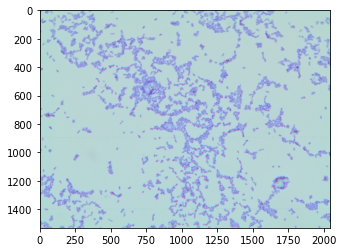

Label is Actinomyces.israel


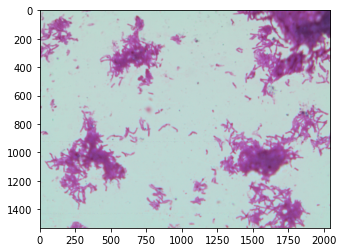

Label is Bacteroides.fragilis


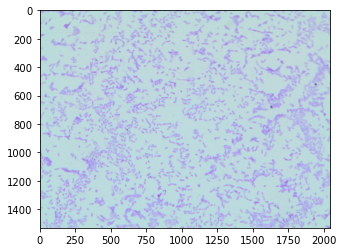

Label is Bifidobacterium.spp


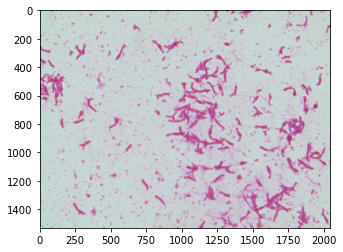

Label is Candida.albicans


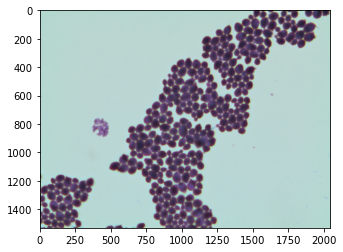

In [5]:
nbPath = os.path.abspath("run.ipynb")
dataFolder = os.path.join(os.path.dirname(nbPath), "data")
classes = glob.glob(os.path.join(dataFolder, "*"))

labels = []
data = []
filename = []
for label in classes:
    files = glob.glob(os.path.join(label, "*"))
    firstImage = True
    for imageFile in files:
        if firstImage:
            print("Label is "+os.path.split(label)[1])
            iShow = cv2.imread(imageFile)
            plt.imshow(iShow)
            plt.show()
            firstImage = False
        data.append(readImageFile(imageFile))
        filename.append(os.path.split(imageFile)[1])
        labels.append(os.path.split(label)[1])

##### Feed data to Inception and get features
##### Create a dict

In [8]:
featureDict = {}
print("\nExtracting features from Model")
for index in range(0, len(data)):
    featureDict[filename[index]] = []
    featureDict[filename[index]] = model.predict(data[index])[0].tolist()
    featureDict[filename[index]].append(labels[index])


Extracting features from Model


##### Writing features to a csv file

In [9]:
print("\nWriting extracted features to file: features.csv")
with open('features.csv', 'w') as f:
    dataFrame = pd.DataFrame(featureDict)
    dataFrame = dataFrame.T
    dataFrame.to_csv("features.csv")
f.close()
print("\nFeatue file written")


Writing extracted features to file: features.csv

Featue file written


### Step 3:
### Train an SVM classifier

##### Prepare data

In [10]:
csvPath = os.path.join(os.path.dirname(nbPath), "features.csv")
dataset = pd.read_csv(csvPath)
X = dataset.iloc[:, 1:-1].values
Y = dataset.iloc[:, -1].values
labelEncoder = LabelEncoder()
Y = labelEncoder.fit_transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 0)

##### Fit Classifier

In [11]:
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

##### Evaluate Classifier

In [12]:
Y_pred = classifier.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion Matrix for the trained model is :")
print(cm)
print("\nAccuracy of trained model is :")
print(accuracy_score(Y_test, Y_pred))


Confusion Matrix for the trained model is :
[[1 0 0]
 [0 3 0]
 [0 0 5]]

Accuracy of trained model is :
1.0


In [14]:
classifierEval = SVC(kernel = 'linear', random_state = 0)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(classifierEval, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 1.000 (0.000)


### Step 4:
### Check results on test folder

In [13]:
def getOneImageFeatures(path):
    I = readImageFile(path)
    features = model.predict(I)
    return features

['Image file Acinetobacter.baumanii_0019.tif is predicted as :Acinetobacter.baumanii']


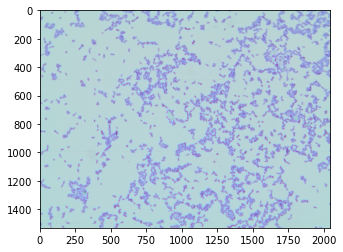

['Image file Acinetobacter.baumanii_0020.tif is predicted as :Acinetobacter.baumanii']


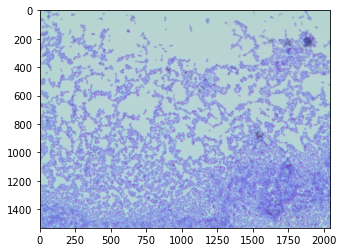

['Image file Actinomyces.israeli_0022.tif is predicted as :Actinomyces.israel']


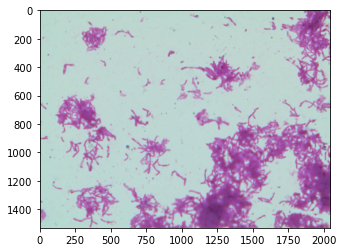

['Image file Actinomyces.israeli_0023.tif is predicted as :Actinomyces.israel']


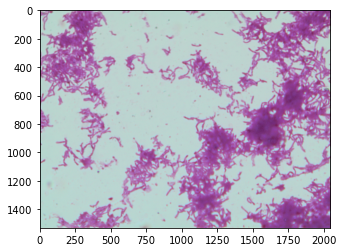

['Image file Bacteroides.fragilis_0022.tif is predicted as :Bacteroides.fragilis']


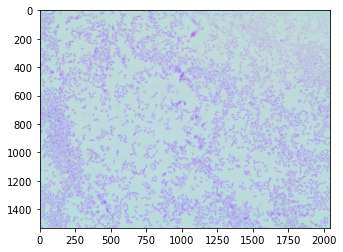

['Image file Bacteroides.fragilis_0023.tif is predicted as :Bacteroides.fragilis']


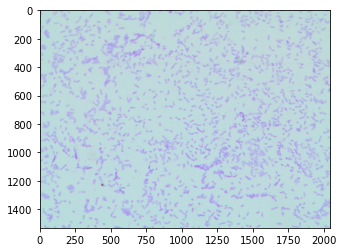

['Image file Bifidobacterium.spp_0021.tif is predicted as :Bifidobacterium.spp']


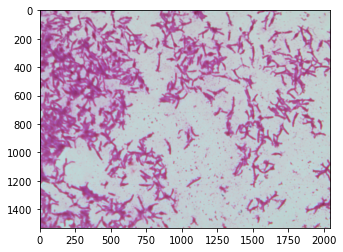

['Image file Bifidobacterium.spp_0022.tif is predicted as :Bifidobacterium.spp']


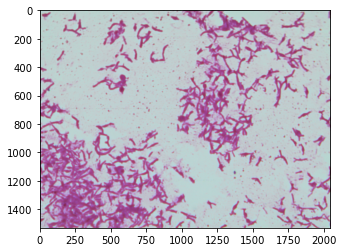

['Image file Candida.albicans_0019.tif is predicted as :Candida.albicans']


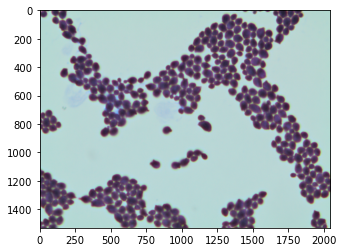

['Image file Candida.albicans_0020.tif is predicted as :Candida.albicans']


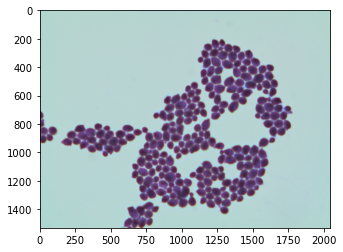

In [15]:
testPath = os.path.join(os.path.dirname(nbPath), "test")
testFiles = glob.glob(os.path.join(testPath, "*.tif"))
for testFile in testFiles:
    features = getOneImageFeatures(testFile)
    prediction = classifier.predict(features)   
    print("Image file "+ os.path.split(testFile)[1]+" is predicted as :" + labelEncoder.inverse_transform(prediction))
    plt.imshow(cv2.imread(testFile))
    plt.show()